# Satelite image 분류
Satellite Remote Sensing Image -RSI-CB256 from https://www.kaggle.com/mahmoudreda55/satellite-image-classification

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
import numpy as np
from PIL import Image
generator = ImageDataGenerator(rescale=1./255, validation_split = 0.2)
directory_train =  '../Suhyun/satelite/data'


train_dataset = generator.flow_from_directory(batch_size=128,
                                                 directory = directory_train,
                                                 shuffle=True,
                                                 target_size=(224, 224), 
                                                 subset="training",
                                                 class_mode='categorical')


valid_dataset = generator.flow_from_directory(batch_size=128,
                                                 directory = directory_train,
                                                 shuffle=True,
                                                 target_size=(224, 224), 
                                                 subset="training",
                                                 class_mode='categorical')


Found 4506 images belonging to 4 classes.
Found 4506 images belonging to 4 classes.


In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
  tf.config.experimental.set_memory_growth(physical_devices[0], True) 

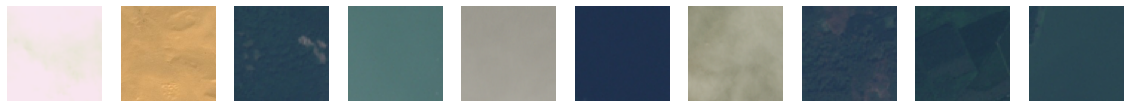

In [3]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(nrows=1,ncols=10,figsize=(20,20))
for i in range(10):
    ax[i].imshow(train_dataset[0][0][i+10])
    ax[i].axis('off')


In [4]:
def hard_swish(features):

  
  features = tf.convert_to_tensor(features)
  fdtype = features.dtype
  return features * tf.nn.relu6(features + tf.cast(3., fdtype)) * (1. / 6.)

In [5]:

def se_block(inputs, ch, ratio=16):

    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(ch//ratio, activation='relu')(x)
    y = tf.keras.layers.Dense(ch, activation='sigmoid')(x)
    y = tf.keras.layers.multiply([inputs, y])
    out = hard_swish(y)
    return out

In [6]:
def dep_bn(inputs, filter : int, kernel :int, stride: int):

  y = tf.keras.layers.Conv2D(filters = filter, kernel_size= kernel, strides= stride, padding= 'same')(inputs)
  bn = tf.keras.layers.BatchNormalization(axis = 1)(y)
  out = tf.nn.relu6(bn)
  
  return out


def Inverted_residual_SEblock(x,  hs: bool, se: bool , filters, kernel, strides,  expansion_ratio ):


    #pointwise
    y = tf.keras.layers.Conv2D(filters = x.get_shape().as_list()[-1]*expansion_ratio, kernel_size=  1, strides = 1, padding= 'same')(x)
    bn = tf.keras.layers.BatchNormalization(axis = 1)(y)
    if hs:
        y_p = hard_swish(bn)
    else:
        y_p = tf.nn.relu6(bn)
    
    
    #depthwise
    y = tf.keras.layers.DepthwiseConv2D(kernel_size=  kernel, strides= strides, padding= 'same', depth_multiplier = 1)(y_p)
    bn = tf.keras.layers.BatchNormalization(axis = 1)(y)
    if hs:
        out = hard_swish(bn)
    else:
        out = tf.nn.relu6(bn)
   
    
    if se: 
        channel = out.get_shape().as_list()[-1]
        out = se_block(out, channel)

    
    #pointwise
    y = tf.keras.layers.Conv2D(filters = filters, kernel_size=  1, strides = 1, padding= 'same')(out)
    bn = tf.keras.layers.BatchNormalization(axis = 1)(y)
    if hs:
        y_p = hard_swish(bn)
    else:
        y_p = tf.nn.relu6(bn)
        
        
    
    if strides == 1:
        if x.shape[3] != filters : 
           x = tf.keras.layers.Conv2D(filters = filters, kernel_size = 1, strides = strides, padding = "same")(x)
        out  = tf.keras.layers.Add()([x, y_p])
   
    

    return y


In [10]:
def create_mobilenetV3(inputs):

   x = dep_bn(inputs, 16, 3, 2)
   x = Inverted_residual_SEblock(x, False, False, 16, 3, 1,1)

   x = Inverted_residual_SEblock(x, False, False, 24, 3, 2, 4)
   x = Inverted_residual_SEblock(x, False, False, 24, 3, 1, 3)
   
   x = Inverted_residual_SEblock(x, False, True, 40, 5, 2, 3)
   x = Inverted_residual_SEblock(x, False, True, 40, 5, 1, 3)
   x = Inverted_residual_SEblock(x, False, True, 40, 5, 1, 3)

   x = Inverted_residual_SEblock(x, True, False, 80, 3, 2, 6)
   x = Inverted_residual_SEblock(x, True, False, 80, 3, 1, 2.5)
   x = Inverted_residual_SEblock(x, True, False, 80, 3, 1, 184/80)
   x = Inverted_residual_SEblock(x, True, False, 80, 3, 1, 184/80)
    
   x = Inverted_residual_SEblock(x, True, True, 112, 3, 1, 6)
   x = Inverted_residual_SEblock(x, True, True, 112, 3, 1, 6)
    
   x = Inverted_residual_SEblock(x, True, True, 160, 5, 2, 6)
   
   x = Inverted_residual_SEblock(x, True, True, 160, 5, 1, 6)
   x = Inverted_residual_SEblock(x, True, True, 160, 5, 1, 6)
   x = dep_bn(x, 960, 1, 1)
   
   t = tf.keras.layers.AveragePooling2D(1)(x)
   t = tf.keras.layers.Flatten()(t)
   outputs = tf.keras.layers.Dense(4, activation='softmax')(t)
   return outputs

In [11]:
inputs = tf.keras.Input(shape=(224,224,3))
outputs = create_mobilenetV3(inputs)
outputs.shape

TensorShape([None, 4])

In [12]:
inputs = tf.keras.Input(shape=(224,224,3))
outputs = create_mobilenetV3(inputs)

model = tf.keras.Model(inputs, outputs)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

In [13]:
model.fit(train_dataset, validation_data=valid_dataset, epochs = 50)

Epoch 1/50
36/36 [==============================] - 23s 479ms/step - loss: 2.1636 - accuracy: 0.4015 - val_loss: 1.3906 - val_accuracy: 0.2663
Epoch 2/50
36/36 [==============================] - 16s 450ms/step - loss: 1.3786 - accuracy: 0.3691 - val_loss: 1.3811 - val_accuracy: 0.2663
Epoch 3/50
36/36 [==============================] - 16s 444ms/step - loss: 0.9732 - accuracy: 0.4587 - val_loss: 1.3804 - val_accuracy: 0.2663
Epoch 4/50
36/36 [==============================] - 16s 441ms/step - loss: 0.9475 - accuracy: 0.4949 - val_loss: 1.3933 - val_accuracy: 0.2663
Epoch 5/50
36/36 [==============================] - 16s 442ms/step - loss: 0.8193 - accuracy: 0.4989 - val_loss: 1.4140 - val_accuracy: 0.2663
Epoch 6/50
36/36 [==============================] - 16s 444ms/step - loss: 0.8392 - accuracy: 0.5195 - val_loss: 1.4851 - val_accuracy: 0.2663
Epoch 7/50
36/36 [==============================] - 16s 447ms/step - loss: 0.7769 - accuracy: 0.5226 - val_loss: 1.6258 - val_accuracy: 0.2663

In [16]:
predictions = model.predict(train_dataset[0][0])

In [18]:
def index_output(prediction) :
    
    index_list = []
    for pred in prediction:
        i = np.argmax(pred)
        index_list.append(i)
    return index_list

In [19]:
y_pred = np.array(index_output(predictions))
y_pred.shape

(128,)

In [20]:
Y_true =[]
for y in train_dataset[0][1]:
    Y_true.append(np.where(y==1))
Y_true = np.squeeze(np.asarray(Y_true))
Y_true.shape

(128,)

In [21]:

from sklearn.metrics import classification_report

print(classification_report(Y_true, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.94      0.72        34
           1       0.00      0.00      0.00        23
           2       0.56      0.97      0.71        34
           3       0.79      0.30      0.43        37

    accuracy                           0.59       128
   macro avg       0.48      0.55      0.47       128
weighted avg       0.53      0.59      0.50       128



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
